In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
from scipy.ndimage import zoom

from skimage.restoration import inpaint
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import ListedColormap
from scipy.ndimage import binary_dilation
from scipy.ndimage import distance_transform_edt
import matplotlib.patches as mpatches
from matplotlib.path import Path
from matplotlib import ticker
from matplotlib import rcParams

import sys
import os

# Add gridder and geo_vtk modules to path using relative paths
current_dir = os.getcwd()
sys.path.insert(0, os.path.join(current_dir, 'gridder'))
sys.path.insert(0, os.path.join(current_dir, 'geo_vtk', 'src'))

from gridder import Geo_Gridder
from vtkclass import VtkClass

# This notebook is prepared for upload to GitHub.
# All dependencies are imported above.
# Please ensure that any local paths (e.g., sys.path.insert) are updated or documented for portability.
# Data files required for execution (e.g., .npy, .gpkg, .txt) should be included or referenced in the repository's README.
# For reproducibility, consider adding requirements.txt or environment.yml with all necessary packages.

In [2]:
#import 
map=np.array([[200,200,200], #anthropogenic
		[157,78,64], #peat
		[0,146,0], #clay
		[194,207,92], #silty
		[255,255,255], #nothing
		[255,255,0], # sand
		[243,225,6], # medium
		[231,195,22], #coarse
		[216,163,32], #gravel
		[95,95,255]]) #shells
map=map/255
my_map=ListedColormap(map,name='IMOD')

# Define labels globally so they are accessible from all functions
labels = np.array([
	'anthropogenic',
	'peat',
	'clay',
	'silt',
	'nothing',
	'sand',
	'sand (m)',
	'sand (c)',
	'gravel',
	'shells'
])

Let's read a file that has multiple boreholes, stack below each. It's typical that borehole are described as top and bottom depths, a geology class. Each boreholes has an x,y, elev inftation associated with it. We need to make a profile out of it. For the moment, we do not provide automated 3D geologica model, we will add one example at a later stage. For now, we will project all boreholes, along a profile. This porjection is based on the coordinates of each borehole. If you feell that the boeholes do not fell into a 2d profile, wait for us to upload a 3D demo.

First we reed the file

In [3]:
import pandas as pd

boreholes=pd.read_csv('borehole_file.csv')
boreholes['major_class'] = boreholes['major_class'].replace('rocks', 'gravel')

The depth per borehole is fedined as top and bottom boundary. Simnce we want to generate image inpainting, we need some sort of regular grid

We found 53 boreholes
We will interpolate on depth every 0.05


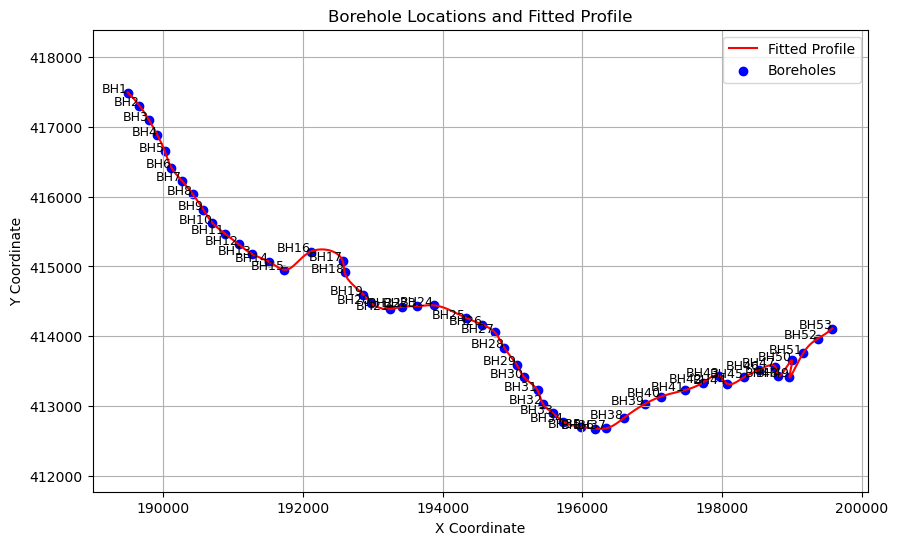

{'clay': 0, 'gravel': 1, 'peat': 2, 'silt': 3}
       depth         x          y   elev major_class  distance_along_profile
0       0.00  189489.4  417489.90  12.92        clay                0.000000
1       0.05  189489.4  417489.90  12.92        clay                0.000000
2       0.10  189489.4  417489.90  12.92        clay                0.000000
3       0.15  189489.4  417489.90  12.92        clay                0.000000
4       0.20  189489.4  417489.90  12.92        clay                0.000000
...      ...       ...        ...    ...         ...                     ...
18997   7.25  199579.1  414111.09  13.69      gravel            13765.586632
18998   7.30  199579.1  414111.09  13.69      gravel            13765.586632
18999   7.35  199579.1  414111.09  13.69      gravel            13765.586632
19000   7.40  199579.1  414111.09  13.69      gravel            13765.586632
19001   7.45  199579.1  414111.09  13.69      gravel            13765.586632

[19002 rows x 6 columns]


In [4]:
int1 = Geo_Gridder(boreholes['x'], boreholes['y'], prepare_data='Yes',boreholes=boreholes,plot='Yes',alpha=1/500)

print(int1.resampled_boreholes)

In [5]:
int1.make_grid(dx=50,dy=0.2)


int1.gridder()

POLYGON ((13765.586632208237 8.94, 13765.586632208237 8.89, 13765.586632208237 8.84, 13765.586632208237 8.79, 13765.586632208237 8.739999999999998, 13765.586632208237 8.69, 13765.586632208237 8.64, 13765.586632208237 8.59, 13765.586632208237 8.54, 13765.586632208237 8.489999999999998, 13765.586632208237 8.44, 13765.586632208237 8.39, 13765.586632208237 8.34, 13765.586632208237 8.29, 13765.586632208237 8.239999999999998, 13765.586632208237 8.19, 13765.586632208237 8.14, 13765.586632208237 8.09, 13765.586632208237 8.04, 13765.586632208237 7.989999999999999, 13765.586632208237 7.9399999999999995, 13765.586632208237 7.89, 13765.586632208237 7.84, 13765.586632208237 7.789999999999999, 13765.586632208237 7.739999999999999, 13765.586632208237 7.6899999999999995, 13765.586632208237 7.64, 13765.586632208237 7.59, 13765.586632208237 7.539999999999999, 13765.586632208237 7.489999999999999, 13765.586632208237 7.4399999999999995, 13765.586632208237 7.39, 13765.586632208237 7.34, 13765.586632208237 

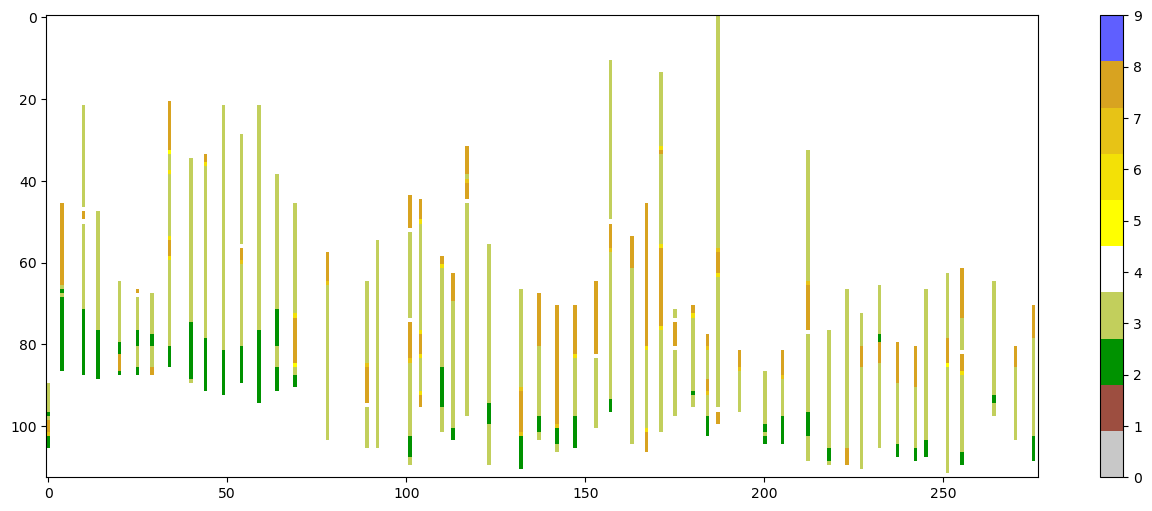

In [6]:
plt.imshow(int1.bs,cmap=my_map, vmin=0, vmax=9)
plt.gca().set_aspect('auto')
plt.colorbar()
plt.gcf().set_size_inches(16, 6)
plt.show()

In [7]:
int1.one_vs_all(x_weight=1,y_weight=3)

e:\karaouli\Projects\2025_ml_inpaint\github\Geology\gridder\gridder.py:879: RuntimeWarning: invalid value encountered in divide
  del3[:,:,i]=del2[:,:,i]/tmp


[1.8        2.         2.2        2.25       2.33333333 2.4
 2.5        2.6        2.75       2.8        3.         3.5
 4.         4.25       5.         5.5        6.         6.33333333
 6.5        6.75       7.         8.        ]


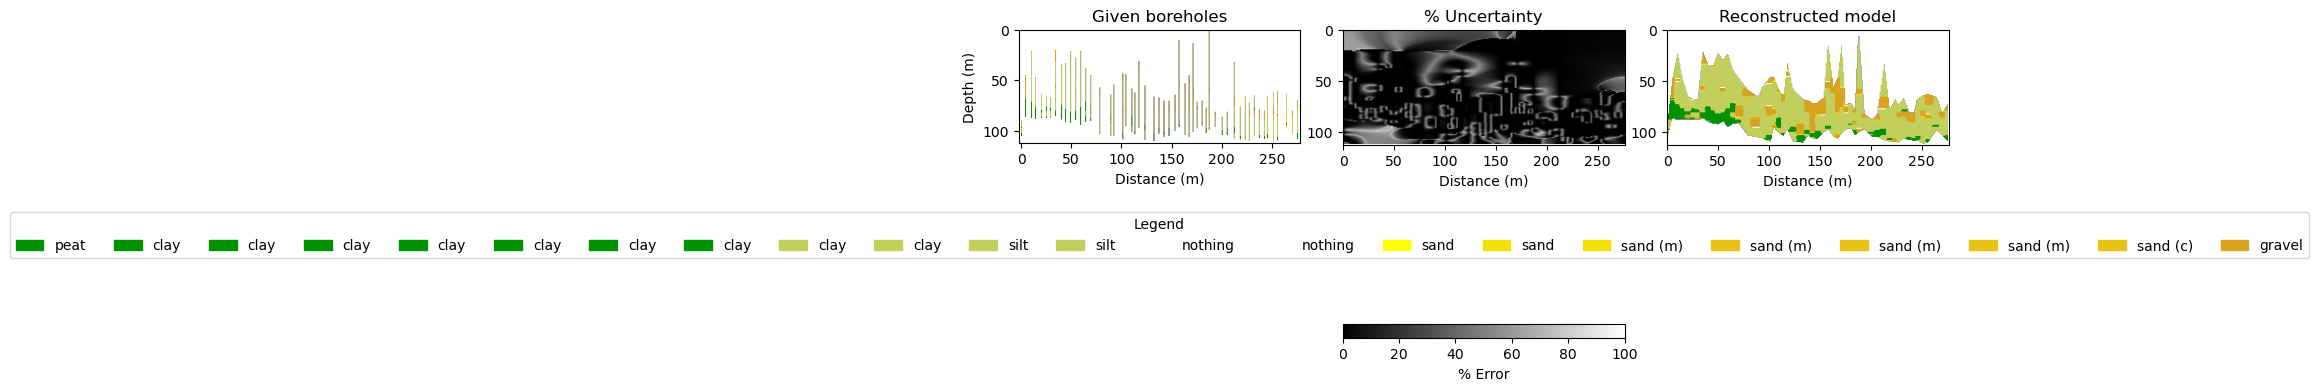

In [8]:
int1.plot_model(cmap=my_map,filename='real_new.pdf',labels=labels)

In [10]:
skata=int1.prediction_data